# DD2412 Final Project - Basic Implementation MNIST


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd drive/MyDrive/Github/AdvanceDL_Poject_Group9/
except:
    print("Unable to connect to google drive")

Unable to connect to google drive


In [2]:
# Import general packages
import os
import copy
import matplotlib.pyplot as plt
import numpy as np

# Variables
%matplotlib inline

In [3]:
# Tensorflow versions
import tensorflow as tf

# Handle not pre-installed packages 
try: 
    import tensorflow_addons as tfa
except:
    os.system("pip install tensorflow-addons")
    import tensorflow_addons as tfa

try: 
    import optuna
except:
    os.system("pip install optuna")
    import optuna

# Print TensorFlow versions
print("TensorFlow version:", tf.__version__)
print("TensorFlow Addon version:", tfa.__version__)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


TensorFlow version: 2.11.0
TensorFlow Addon version: 0.18.0


In [4]:
import self_classifier as sc

## Config

In [5]:
# Create config variable
config = {
    # Data Parameter
    'DATASET' : tf.keras.datasets.cifar100,
    'IMAGE_SHAPE' : (32,32,3),
    'IMAGE_SIZE' : 32, 
    'BATCH_SIZE' : 64,
    'CLASS_COUNT' : 100,
    'N_AUG' : 2,
    # Training parameters
    'LR_SCHED' : "WarmUpCosineDecay",
    'OPTIM' : tf.keras.optimizers.Adam(),
    'EPOCHS' : 100,
    'MAX_LR' : 0.005,
}

## Data Loading and Augmentation

In [6]:
train_loader = sc.DataLoader(in_path="datasets/cifar100/train", mkdir=True)
train_ds = train_loader.get_train(config=config)

Stored training dataset found, loading...[done]
Loaded dataset information:
 => Batch Count: 782
 => Batch Size: 64
 => Augmentations: 2


In [7]:
test_loader = sc.DataLoader(in_path="datasets/cifar100/test", mkdir=True)
test_ds = test_loader.get_test(config=config)

Stored test dataset found, loading...[done]
Loaded dataset information:
 => Batch Count: 157
 => Batch Size: 64
 => Augmentations: 2


## Train Network

In [8]:
def training_run():
    # Create a data recorder and fit the data
    recorder = sc.DataRecorder()

    # Instansiate loss function
    loss_object_test = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Instansiate SelfClassifier loss function
    loss_object_train = sc.SelfClassifier(n_batch=config['BATCH_SIZE'], 
                        n_class=config['CLASS_COUNT'], t_r=0.1, t_c=0.05)
    # Instansiate optimizer 
    optimizer = config['OPTIM']
    optimizer.lr = 0.0001
    #optimizer.learning_rate = sc.lr_schedular(config, config['LR_SCHED'],len(train_ds))
    
    # Select backbone 
    backbone = "EfficientNetB1"

    # Create an instance of the model
    model = sc.PretrainedModel(pre_model=backbone,
                               input_shape=config['IMAGE_SHAPE'],
                               output_shape=config['CLASS_COUNT'])

    learner = sc.UnderSupervisedLearner(model=model, optimizer=optimizer,
                                 loss_object_train=loss_object_train,
                                 loss_object_test=loss_object_test,
                                 recorder=recorder)
    # Train the model
    return learner.fit(config=config, train_ds=train_ds,
                       test_ds=test_ds, plot_every=5)

============================== EPOCH 1 ==============================


Validation: 100%|██████████| 157/157 [00:17<00:00,  9.20it/s]


Epoch 1, Learning Rate: 0.00010, Epoch time: 68.69 seconds
Loss: 4.531, Valid Loss: 4.4428, NMI: 0.7337, AMI: 0.5884, ARI: 0.5653, ACC: 0.6869, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.16it/s]


Epoch 2, Learning Rate: 0.00010, Epoch time: 38.71 seconds
Loss: 4.472, Valid Loss: 4.4027, NMI: 0.7715, AMI: 0.6165, ARI: 0.5908, ACC: 0.7124, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


Epoch 3, Learning Rate: 0.00010, Epoch time: 38.33 seconds
Loss: 4.447, Valid Loss: 4.3878, NMI: 0.7757, AMI: 0.6043, ARI: 0.5810, ACC: 0.7033, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.83it/s]


Epoch 4, Learning Rate: 0.00010, Epoch time: 38.75 seconds
Loss: 4.428, Valid Loss: 4.3559, NMI: 0.8028, AMI: 0.6100, ARI: 0.5876, ACC: 0.6940, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.00it/s]


Epoch 5, Learning Rate: 0.00010, Epoch time: 38.50 seconds
Loss: 4.402, Valid Loss: 4.3442, NMI: 0.8000, AMI: 0.5862, ARI: 0.5621, ACC: 0.6784, 


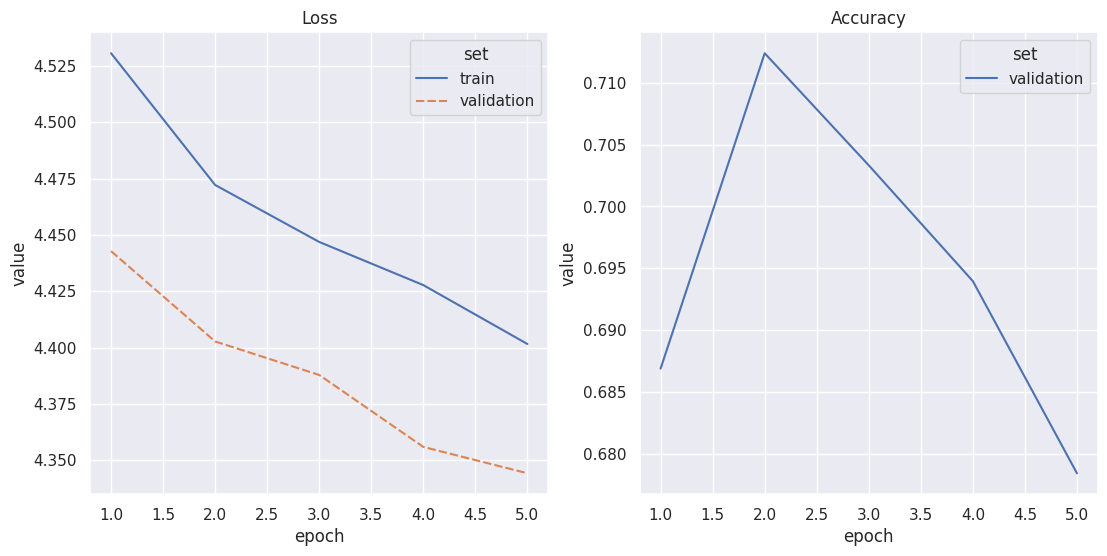

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


Epoch 6, Learning Rate: 0.00010, Epoch time: 37.34 seconds
Loss: 4.394, Valid Loss: 4.3455, NMI: 0.7953, AMI: 0.5856, ARI: 0.5603, ACC: 0.6774, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.81it/s]


Epoch 7, Learning Rate: 0.00010, Epoch time: 37.80 seconds
Loss: 4.392, Valid Loss: 4.3271, NMI: 0.8094, AMI: 0.5918, ARI: 0.5680, ACC: 0.6826, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


Epoch 8, Learning Rate: 0.00010, Epoch time: 35.19 seconds
Loss: 4.374, Valid Loss: 4.3010, NMI: 0.8294, AMI: 0.6178, ARI: 0.5971, ACC: 0.6979, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.98it/s]


Epoch 9, Learning Rate: 0.00010, Epoch time: 35.67 seconds
Loss: 4.362, Valid Loss: 4.3122, NMI: 0.8073, AMI: 0.5690, ARI: 0.5447, ACC: 0.6610, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


Epoch 10, Learning Rate: 0.00010, Epoch time: 35.66 seconds
Loss: 4.354, Valid Loss: 4.3219, NMI: 0.8004, AMI: 0.5659, ARI: 0.5405, ACC: 0.6572, 


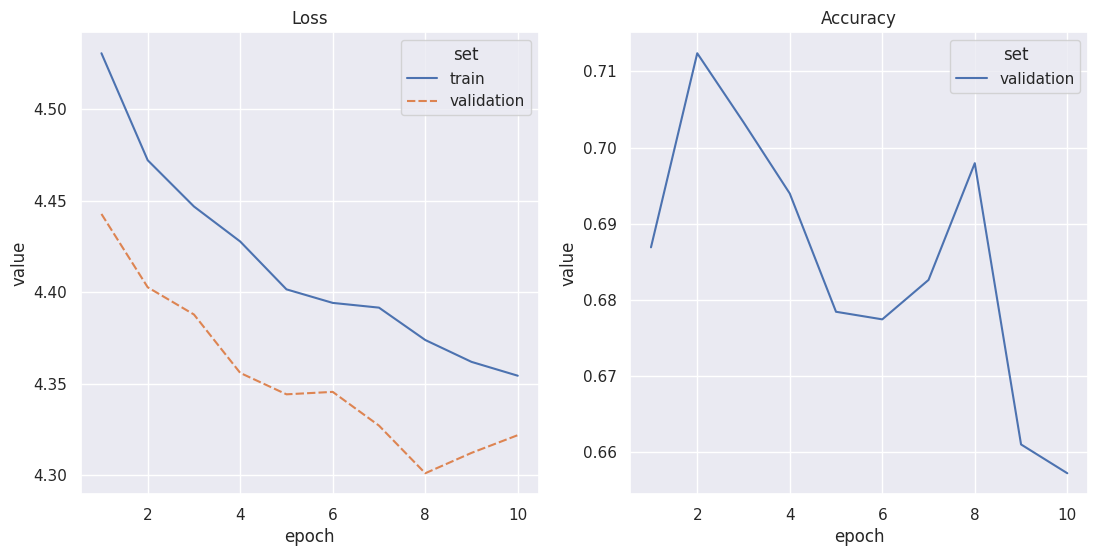

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.10it/s]


Epoch 11, Learning Rate: 0.00010, Epoch time: 35.68 seconds
Loss: 4.354, Valid Loss: 4.2932, NMI: 0.8379, AMI: 0.6423, ARI: 0.6221, ACC: 0.7195, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.45it/s]


Epoch 12, Learning Rate: 0.00010, Epoch time: 35.00 seconds
Loss: 4.351, Valid Loss: 4.3052, NMI: 0.8170, AMI: 0.5952, ARI: 0.5720, ACC: 0.6862, 
============================== EPOCH 13 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


Epoch 13, Learning Rate: 0.00010, Epoch time: 35.02 seconds
Loss: 4.351, Valid Loss: 4.3011, NMI: 0.8170, AMI: 0.5955, ARI: 0.5716, ACC: 0.6848, 
============================== EPOCH 14 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


Epoch 14, Learning Rate: 0.00010, Epoch time: 34.71 seconds
Loss: 4.349, Valid Loss: 4.2988, NMI: 0.8192, AMI: 0.5967, ARI: 0.5730, ACC: 0.6886, 
============================== EPOCH 15 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.47it/s]


Epoch 15, Learning Rate: 0.00010, Epoch time: 34.49 seconds
Loss: 4.344, Valid Loss: 4.3081, NMI: 0.8007, AMI: 0.5588, ARI: 0.5331, ACC: 0.6566, 


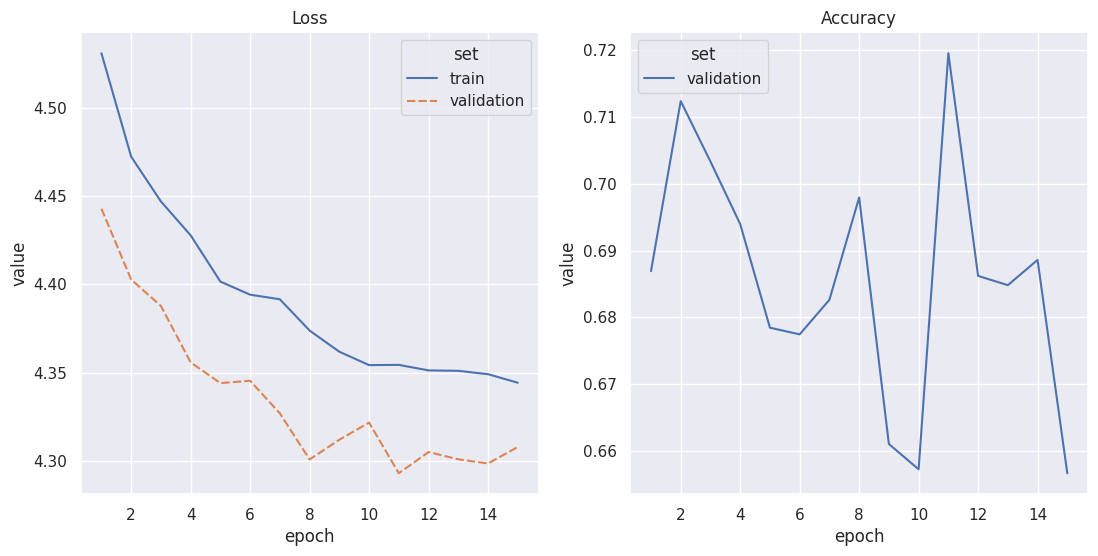

============================== EPOCH 16 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


Epoch 16, Learning Rate: 0.00010, Epoch time: 34.06 seconds
Loss: 4.344, Valid Loss: 4.2933, NMI: 0.8228, AMI: 0.6065, ARI: 0.5839, ACC: 0.6952, 
============================== EPOCH 17 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.28it/s]


Epoch 17, Learning Rate: 0.00010, Epoch time: 34.10 seconds
Loss: 4.340, Valid Loss: 4.2814, NMI: 0.8467, AMI: 0.6585, ARI: 0.6394, ACC: 0.7354, 
============================== EPOCH 18 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.98it/s]


Epoch 18, Learning Rate: 0.00010, Epoch time: 33.99 seconds
Loss: 4.337, Valid Loss: 4.3003, NMI: 0.8102, AMI: 0.5868, ARI: 0.5606, ACC: 0.6792, 
============================== EPOCH 19 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.88it/s]


Epoch 19, Learning Rate: 0.00010, Epoch time: 34.12 seconds
Loss: 4.336, Valid Loss: 4.2798, NMI: 0.8337, AMI: 0.6113, ARI: 0.5906, ACC: 0.6936, 
============================== EPOCH 20 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.79it/s]


Epoch 20, Learning Rate: 0.00010, Epoch time: 33.86 seconds
Loss: 4.328, Valid Loss: 4.2863, NMI: 0.8251, AMI: 0.5969, ARI: 0.5750, ACC: 0.6885, 


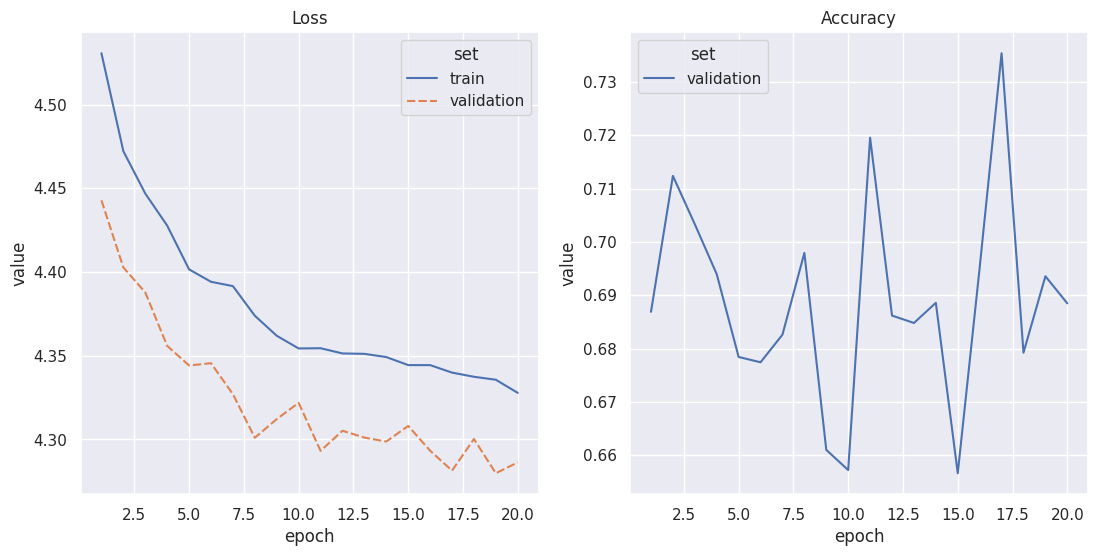

============================== EPOCH 21 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


Epoch 21, Learning Rate: 0.00010, Epoch time: 34.06 seconds
Loss: 4.328, Valid Loss: 4.2997, NMI: 0.7955, AMI: 0.5305, ARI: 0.5036, ACC: 0.6368, 
============================== EPOCH 22 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.65it/s]


Epoch 22, Learning Rate: 0.00010, Epoch time: 33.72 seconds
Loss: 4.325, Valid Loss: 4.2926, NMI: 0.8087, AMI: 0.5541, ARI: 0.5300, ACC: 0.6552, 
============================== EPOCH 23 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.78it/s]


Epoch 23, Learning Rate: 0.00010, Epoch time: 33.68 seconds
Loss: 4.326, Valid Loss: 4.2920, NMI: 0.8052, AMI: 0.5567, ARI: 0.5300, ACC: 0.6597, 
============================== EPOCH 24 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.62it/s]


Epoch 24, Learning Rate: 0.00010, Epoch time: 34.06 seconds
Loss: 4.320, Valid Loss: 4.2809, NMI: 0.8253, AMI: 0.5978, ARI: 0.5748, ACC: 0.6877, 
============================== EPOCH 25 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.31it/s]


Epoch 25, Learning Rate: 0.00010, Epoch time: 34.21 seconds
Loss: 4.320, Valid Loss: 4.2788, NMI: 0.8151, AMI: 0.5666, ARI: 0.5412, ACC: 0.6635, 


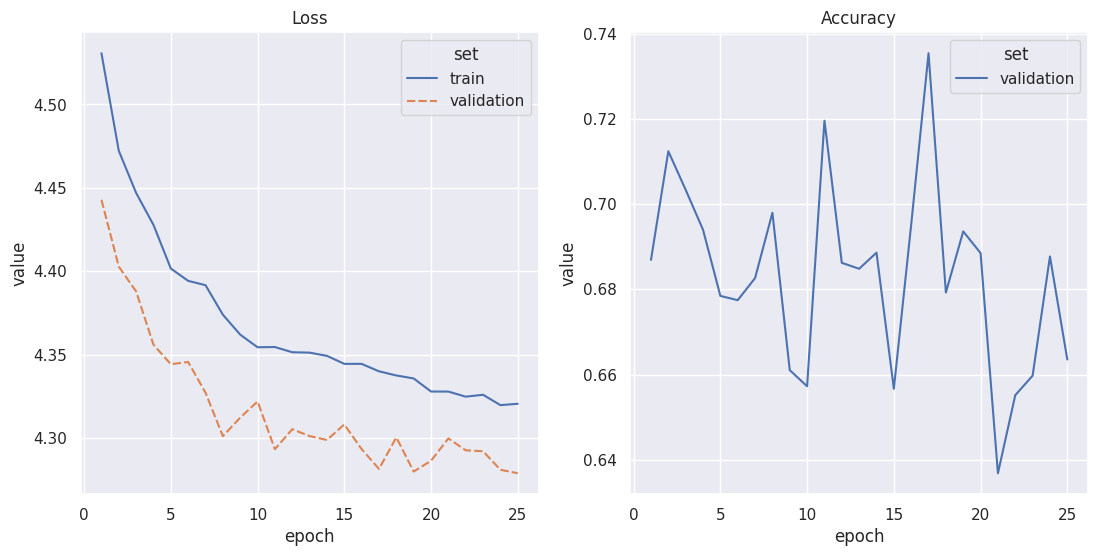

============================== EPOCH 26 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.58it/s]


Epoch 26, Learning Rate: 0.00010, Epoch time: 33.82 seconds
Loss: 4.311, Valid Loss: 4.2592, NMI: 0.8360, AMI: 0.6107, ARI: 0.5877, ACC: 0.6969, 
============================== EPOCH 27 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.43it/s]


Epoch 27, Learning Rate: 0.00010, Epoch time: 32.98 seconds
Loss: 4.305, Valid Loss: 4.2760, NMI: 0.8170, AMI: 0.5578, ARI: 0.5331, ACC: 0.6553, 
============================== EPOCH 28 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.83it/s]


Epoch 28, Learning Rate: 0.00010, Epoch time: 34.18 seconds
Loss: 4.305, Valid Loss: 4.2684, NMI: 0.8221, AMI: 0.5683, ARI: 0.5437, ACC: 0.6683, 
============================== EPOCH 29 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


Epoch 29, Learning Rate: 0.00010, Epoch time: 34.08 seconds
Loss: 4.306, Valid Loss: 4.2679, NMI: 0.8318, AMI: 0.6007, ARI: 0.5772, ACC: 0.6884, 
============================== EPOCH 30 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.44it/s]


Epoch 30, Learning Rate: 0.00010, Epoch time: 33.89 seconds
Loss: 4.303, Valid Loss: 4.2795, NMI: 0.8103, AMI: 0.5560, ARI: 0.5281, ACC: 0.6533, 


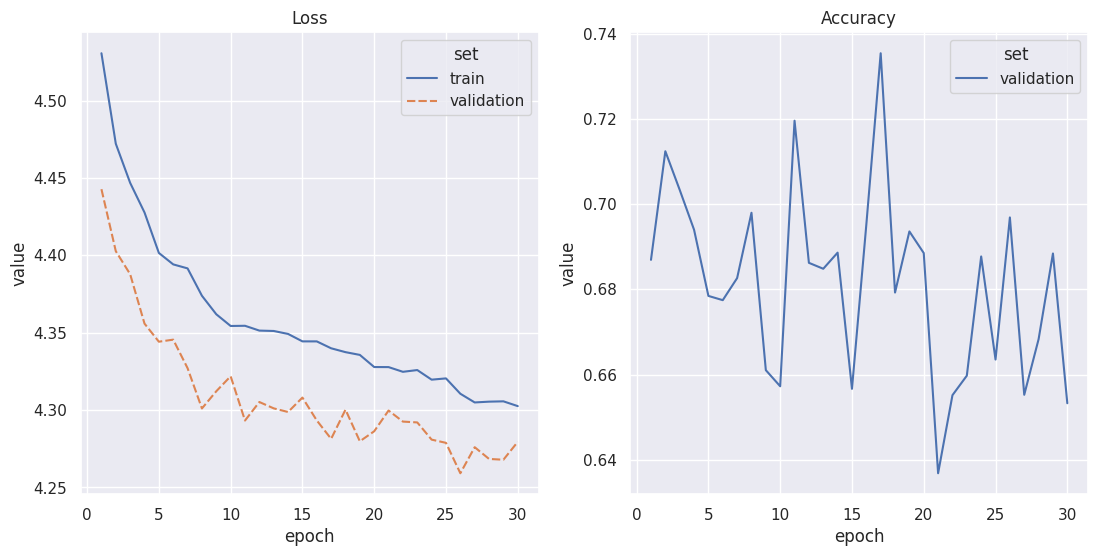

============================== EPOCH 31 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.66it/s]


Epoch 31, Learning Rate: 0.00010, Epoch time: 33.66 seconds
Loss: 4.297, Valid Loss: 4.2533, NMI: 0.8425, AMI: 0.6316, ARI: 0.6096, ACC: 0.7106, 
============================== EPOCH 32 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


Epoch 32, Learning Rate: 0.00010, Epoch time: 34.21 seconds
Loss: 4.308, Valid Loss: 4.2553, NMI: 0.8371, AMI: 0.6101, ARI: 0.5917, ACC: 0.6968, 
============================== EPOCH 33 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.93it/s]


Epoch 33, Learning Rate: 0.00010, Epoch time: 34.13 seconds
Loss: 4.300, Valid Loss: 4.2480, NMI: 0.8451, AMI: 0.6289, ARI: 0.6078, ACC: 0.7147, 
============================== EPOCH 34 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


Epoch 34, Learning Rate: 0.00010, Epoch time: 34.38 seconds
Loss: 4.306, Valid Loss: 4.2692, NMI: 0.8211, AMI: 0.5693, ARI: 0.5442, ACC: 0.6654, 
============================== EPOCH 35 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


Epoch 35, Learning Rate: 0.00010, Epoch time: 33.81 seconds
Loss: 4.293, Valid Loss: 4.2753, NMI: 0.8111, AMI: 0.5448, ARI: 0.5214, ACC: 0.6486, 


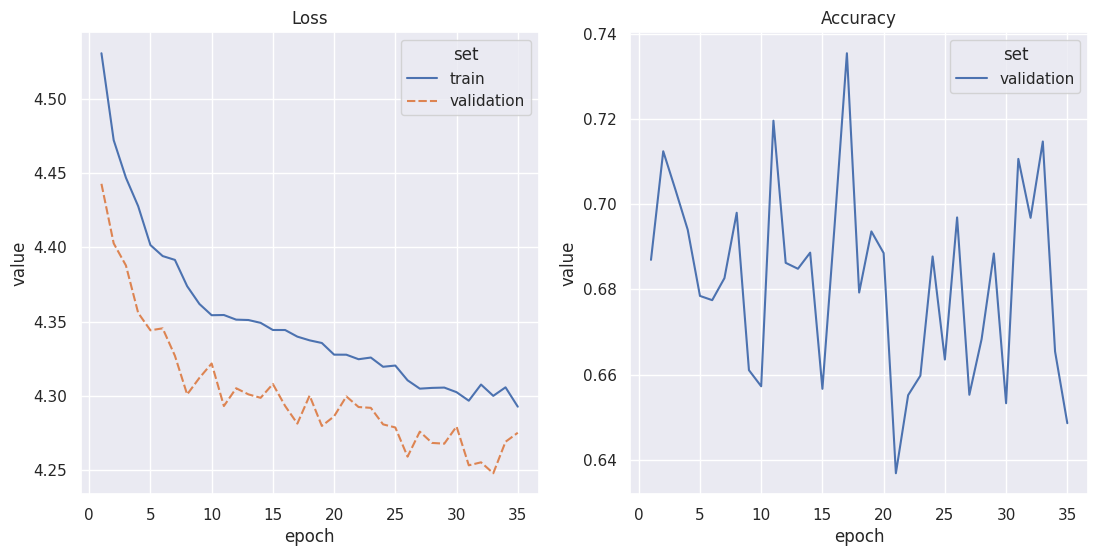

============================== EPOCH 36 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.41it/s]


Epoch 36, Learning Rate: 0.00010, Epoch time: 33.38 seconds
Loss: 4.297, Valid Loss: 4.2554, NMI: 0.8368, AMI: 0.6134, ARI: 0.5906, ACC: 0.7014, 
============================== EPOCH 37 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.03it/s]


Epoch 37, Learning Rate: 0.00010, Epoch time: 33.98 seconds
Loss: 4.289, Valid Loss: 4.2493, NMI: 0.8355, AMI: 0.5938, ARI: 0.5707, ACC: 0.6892, 
============================== EPOCH 38 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.17it/s]


Epoch 38, Learning Rate: 0.00010, Epoch time: 34.04 seconds
Loss: 4.285, Valid Loss: 4.2613, NMI: 0.8165, AMI: 0.5438, ARI: 0.5198, ACC: 0.6481, 
============================== EPOCH 39 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


Epoch 39, Learning Rate: 0.00010, Epoch time: 34.12 seconds
Loss: 4.286, Valid Loss: 4.2515, NMI: 0.8243, AMI: 0.5582, ARI: 0.5345, ACC: 0.6615, 
============================== EPOCH 40 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.33it/s]


Epoch 40, Learning Rate: 0.00010, Epoch time: 33.98 seconds
Loss: 4.289, Valid Loss: 4.2341, NMI: 0.8503, AMI: 0.6309, ARI: 0.6112, ACC: 0.7160, 


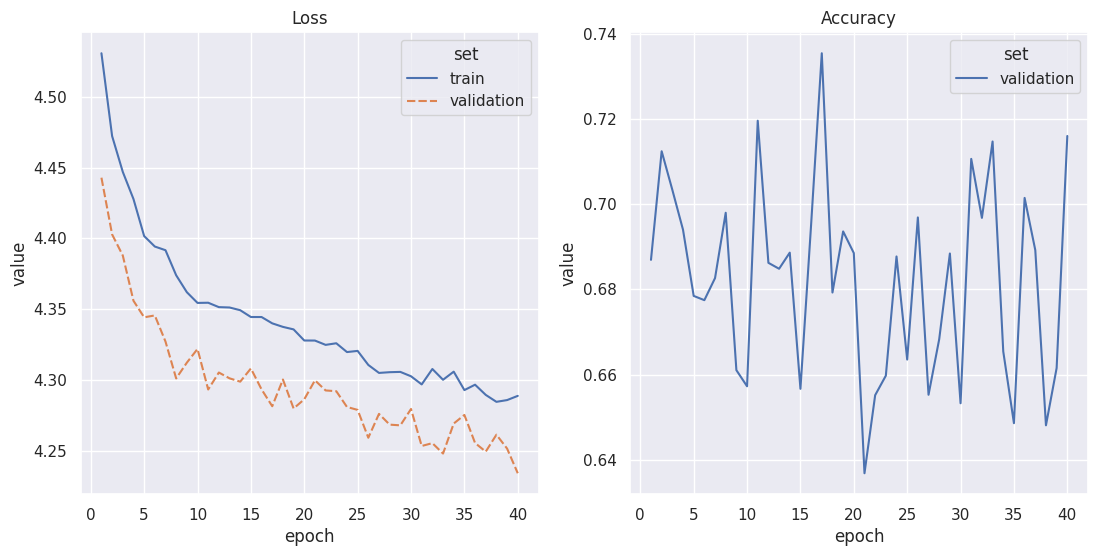

============================== EPOCH 41 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.18it/s]


Epoch 41, Learning Rate: 0.00010, Epoch time: 34.18 seconds
Loss: 4.283, Valid Loss: 4.2549, NMI: 0.8258, AMI: 0.5580, ARI: 0.5367, ACC: 0.6561, 
============================== EPOCH 42 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.76it/s]


Epoch 42, Learning Rate: 0.00010, Epoch time: 34.26 seconds
Loss: 4.279, Valid Loss: 4.2275, NMI: 0.8594, AMI: 0.6536, ARI: 0.6348, ACC: 0.7316, 
============================== EPOCH 43 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


Epoch 43, Learning Rate: 0.00010, Epoch time: 33.82 seconds
Loss: 4.284, Valid Loss: 4.2530, NMI: 0.8266, AMI: 0.5711, ARI: 0.5479, ACC: 0.6664, 
============================== EPOCH 44 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.98it/s]


Epoch 44, Learning Rate: 0.00010, Epoch time: 34.82 seconds
Loss: 4.281, Valid Loss: 4.2458, NMI: 0.8329, AMI: 0.5856, ARI: 0.5648, ACC: 0.6842, 
============================== EPOCH 45 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.01it/s]


Epoch 45, Learning Rate: 0.00010, Epoch time: 34.50 seconds
Loss: 4.284, Valid Loss: 4.2374, NMI: 0.8462, AMI: 0.6112, ARI: 0.5911, ACC: 0.6971, 


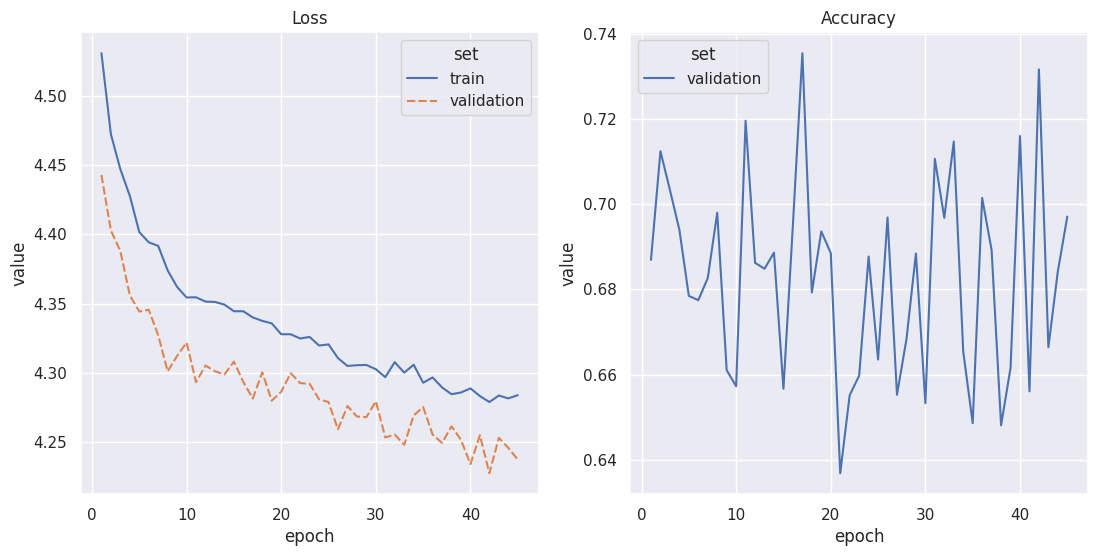

============================== EPOCH 46 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


Epoch 46, Learning Rate: 0.00010, Epoch time: 34.04 seconds
Loss: 4.274, Valid Loss: 4.2532, NMI: 0.8198, AMI: 0.5653, ARI: 0.5402, ACC: 0.6683, 
============================== EPOCH 47 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.31it/s]


Epoch 47, Learning Rate: 0.00010, Epoch time: 34.31 seconds
Loss: 4.274, Valid Loss: 4.2255, NMI: 0.8489, AMI: 0.6255, ARI: 0.6066, ACC: 0.7128, 
============================== EPOCH 48 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.06it/s]


Epoch 48, Learning Rate: 0.00010, Epoch time: 34.00 seconds
Loss: 4.274, Valid Loss: 4.2382, NMI: 0.8426, AMI: 0.6071, ARI: 0.5869, ACC: 0.6961, 
============================== EPOCH 49 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.78it/s]


Epoch 49, Learning Rate: 0.00010, Epoch time: 34.25 seconds
Loss: 4.276, Valid Loss: 4.2491, NMI: 0.8223, AMI: 0.5528, ARI: 0.5306, ACC: 0.6518, 
============================== EPOCH 50 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.57it/s]


Epoch 50, Learning Rate: 0.00010, Epoch time: 33.91 seconds
Loss: 4.264, Valid Loss: 4.2285, NMI: 0.8455, AMI: 0.6016, ARI: 0.5794, ACC: 0.6895, 


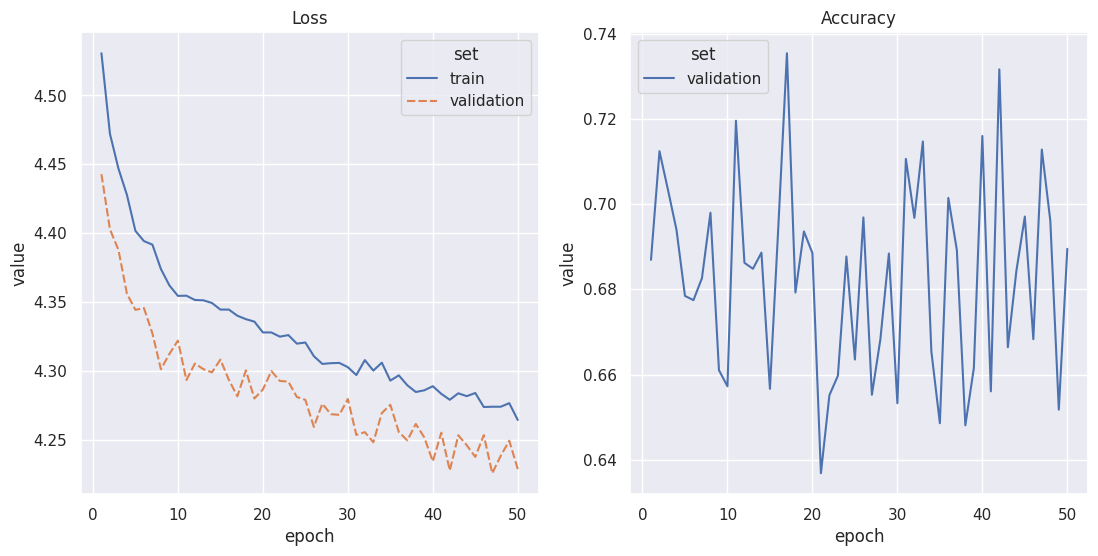

============================== EPOCH 51 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.07it/s]


Epoch 51, Learning Rate: 0.00010, Epoch time: 34.29 seconds
Loss: 4.259, Valid Loss: 4.2484, NMI: 0.8182, AMI: 0.5350, ARI: 0.5109, ACC: 0.6413, 
============================== EPOCH 52 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


Epoch 52, Learning Rate: 0.00010, Epoch time: 33.86 seconds
Loss: 4.259, Valid Loss: 4.2440, NMI: 0.8206, AMI: 0.5376, ARI: 0.5158, ACC: 0.6426, 
============================== EPOCH 53 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.98it/s]


Epoch 53, Learning Rate: 0.00010, Epoch time: 33.85 seconds
Loss: 4.267, Valid Loss: 4.2456, NMI: 0.8220, AMI: 0.5410, ARI: 0.5173, ACC: 0.6452, 
============================== EPOCH 54 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.99it/s]


Epoch 54, Learning Rate: 0.00010, Epoch time: 34.10 seconds
Loss: 4.270, Valid Loss: 4.2334, NMI: 0.8370, AMI: 0.5777, ARI: 0.5564, ACC: 0.6743, 
============================== EPOCH 55 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.05it/s]


Epoch 55, Learning Rate: 0.00010, Epoch time: 34.03 seconds
Loss: 4.263, Valid Loss: 4.2237, NMI: 0.8431, AMI: 0.6018, ARI: 0.5814, ACC: 0.6962, 


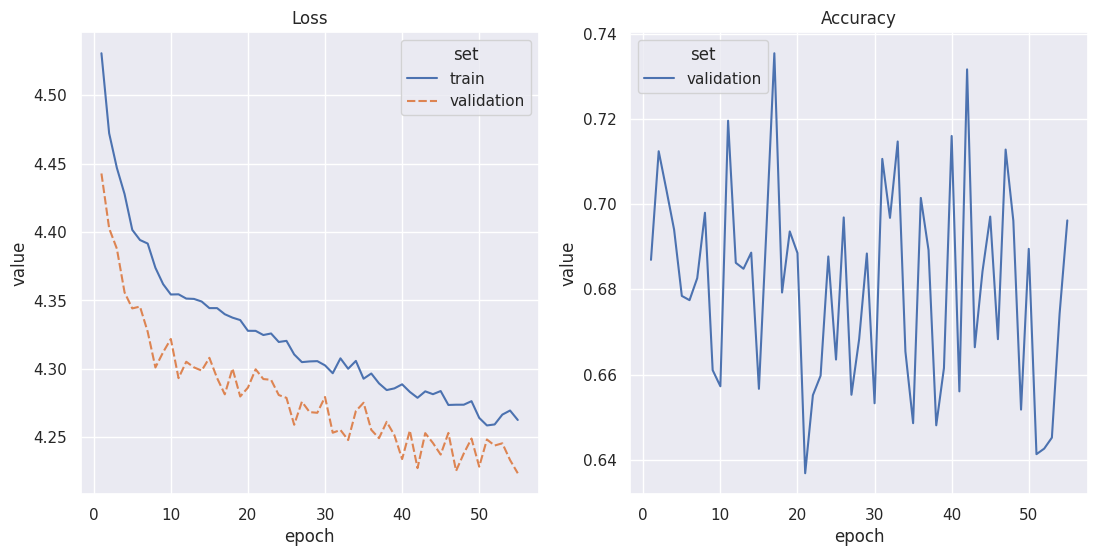

============================== EPOCH 56 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.52it/s]


Epoch 56, Learning Rate: 0.00010, Epoch time: 33.85 seconds
Loss: 4.263, Valid Loss: 4.2284, NMI: 0.8422, AMI: 0.5952, ARI: 0.5743, ACC: 0.6891, 
============================== EPOCH 57 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.15it/s]


Epoch 57, Learning Rate: 0.00010, Epoch time: 34.08 seconds
Loss: 4.255, Valid Loss: 4.2509, NMI: 0.8152, AMI: 0.5228, ARI: 0.4961, ACC: 0.6327, 
============================== EPOCH 58 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.84it/s]


Epoch 58, Learning Rate: 0.00010, Epoch time: 34.65 seconds
Loss: 4.260, Valid Loss: 4.2263, NMI: 0.8412, AMI: 0.6009, ARI: 0.5789, ACC: 0.6892, 
============================== EPOCH 59 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.09it/s]


Epoch 59, Learning Rate: 0.00010, Epoch time: 49.65 seconds
Loss: 4.262, Valid Loss: 4.2151, NMI: 0.8542, AMI: 0.6323, ARI: 0.6109, ACC: 0.7161, 
============================== EPOCH 60 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.80it/s]


Epoch 60, Learning Rate: 0.00010, Epoch time: 35.10 seconds
Loss: 4.253, Valid Loss: 4.2238, NMI: 0.8386, AMI: 0.5938, ARI: 0.5708, ACC: 0.6882, 


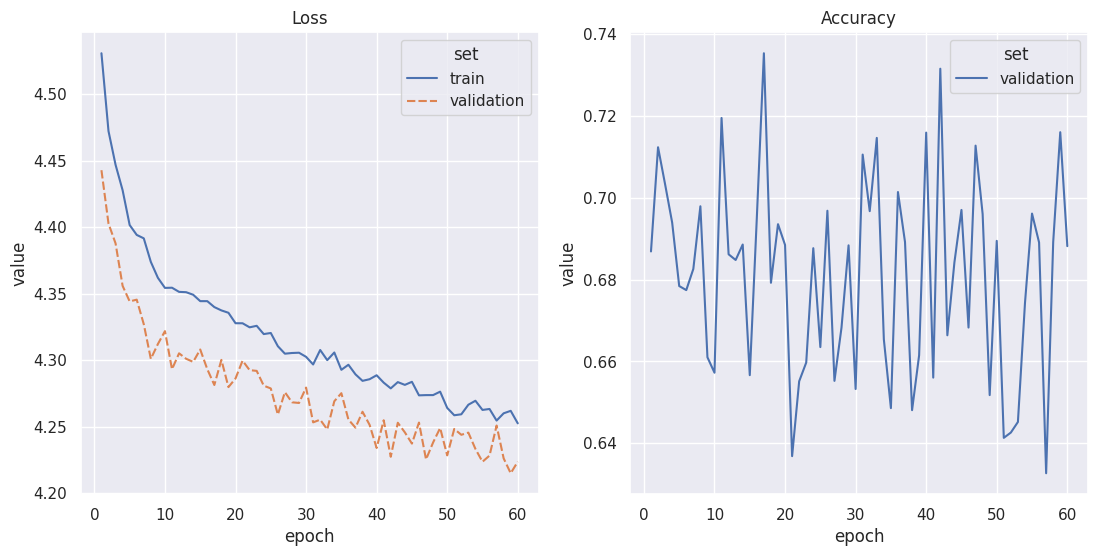

============================== EPOCH 61 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.98it/s]


Epoch 61, Learning Rate: 0.00010, Epoch time: 34.12 seconds
Loss: 4.254, Valid Loss: 4.2549, NMI: 0.8081, AMI: 0.5195, ARI: 0.4946, ACC: 0.6290, 
============================== EPOCH 62 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.89it/s]


Epoch 62, Learning Rate: 0.00010, Epoch time: 35.02 seconds
Loss: 4.252, Valid Loss: 4.2339, NMI: 0.8360, AMI: 0.5781, ARI: 0.5559, ACC: 0.6715, 
============================== EPOCH 63 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


Epoch 63, Learning Rate: 0.00010, Epoch time: 34.69 seconds
Loss: 4.259, Valid Loss: 4.2154, NMI: 0.8571, AMI: 0.6407, ARI: 0.6212, ACC: 0.7205, 
============================== EPOCH 64 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.41it/s]


Epoch 64, Learning Rate: 0.00010, Epoch time: 34.37 seconds
Loss: 4.251, Valid Loss: 4.2261, NMI: 0.8465, AMI: 0.6067, ARI: 0.5864, ACC: 0.6972, 
============================== EPOCH 65 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.94it/s]


Epoch 65, Learning Rate: 0.00010, Epoch time: 34.58 seconds
Loss: 4.248, Valid Loss: 4.2346, NMI: 0.8354, AMI: 0.5741, ARI: 0.5493, ACC: 0.6707, 


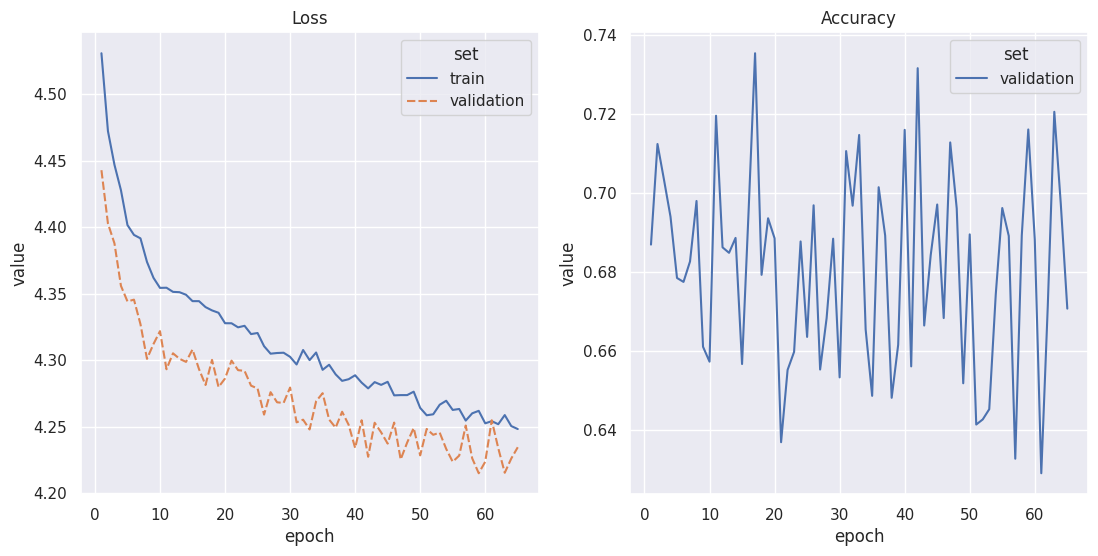

============================== EPOCH 66 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.87it/s]


Epoch 66, Learning Rate: 0.00010, Epoch time: 34.99 seconds
Loss: 4.253, Valid Loss: 4.2232, NMI: 0.8473, AMI: 0.6049, ARI: 0.5848, ACC: 0.6967, 
============================== EPOCH 67 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.07it/s]


Epoch 67, Learning Rate: 0.00010, Epoch time: 34.33 seconds
Loss: 4.249, Valid Loss: 4.2269, NMI: 0.8402, AMI: 0.5877, ARI: 0.5670, ACC: 0.6782, 
============================== EPOCH 68 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.91it/s]


Epoch 68, Learning Rate: 0.00010, Epoch time: 34.73 seconds
Loss: 4.247, Valid Loss: 4.2224, NMI: 0.8374, AMI: 0.5619, ARI: 0.5407, ACC: 0.6598, 
============================== EPOCH 69 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.88it/s]


Epoch 69, Learning Rate: 0.00010, Epoch time: 34.97 seconds
Loss: 4.243, Valid Loss: 4.2347, NMI: 0.8231, AMI: 0.5350, ARI: 0.5126, ACC: 0.6380, 
============================== EPOCH 70 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.92it/s]


Epoch 70, Learning Rate: 0.00010, Epoch time: 33.79 seconds
Loss: 4.241, Valid Loss: 4.2115, NMI: 0.8485, AMI: 0.5918, ARI: 0.5717, ACC: 0.6856, 


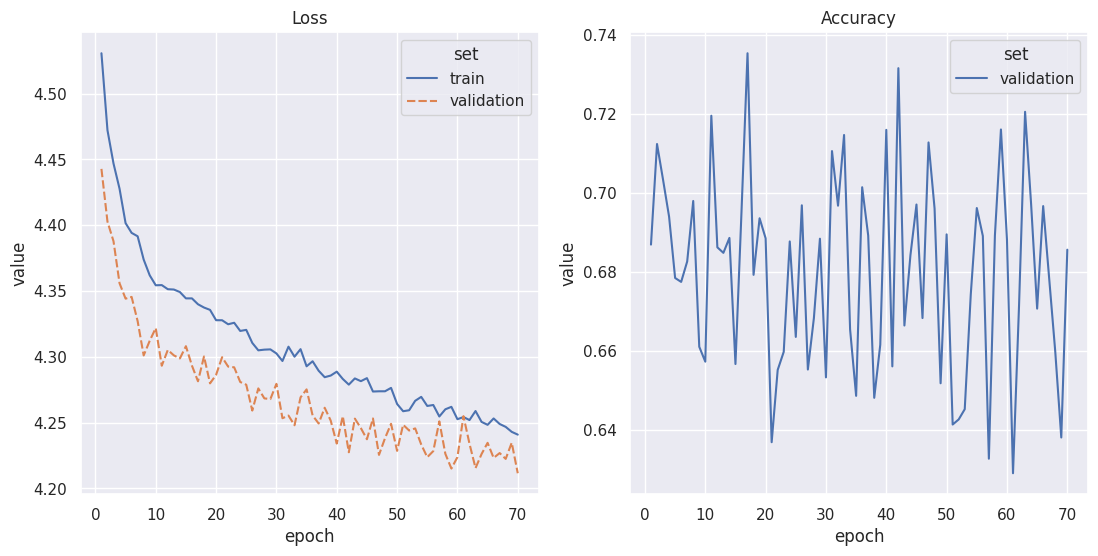

============================== EPOCH 71 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.18it/s]


Epoch 71, Learning Rate: 0.00010, Epoch time: 34.53 seconds
Loss: 4.242, Valid Loss: 4.2162, NMI: 0.8479, AMI: 0.6002, ARI: 0.5784, ACC: 0.6913, 
============================== EPOCH 72 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.83it/s]


Epoch 72, Learning Rate: 0.00010, Epoch time: 34.22 seconds
Loss: 4.234, Valid Loss: 4.2190, NMI: 0.8361, AMI: 0.5711, ARI: 0.5499, ACC: 0.6717, 
============================== EPOCH 73 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


Epoch 73, Learning Rate: 0.00010, Epoch time: 34.74 seconds
Loss: 4.236, Valid Loss: 4.2276, NMI: 0.8300, AMI: 0.5443, ARI: 0.5226, ACC: 0.6505, 
============================== EPOCH 74 ==============================


Validation: 100%|██████████| 157/157 [00:07<00:00, 19.80it/s]


Epoch 74, Learning Rate: 0.00010, Epoch time: 33.03 seconds
Loss: 4.235, Valid Loss: 4.2031, NMI: 0.8540, AMI: 0.6116, ARI: 0.5914, ACC: 0.7031, 
============================== EPOCH 75 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 19.10it/s]


Epoch 75, Learning Rate: 0.00010, Epoch time: 31.98 seconds
Loss: 4.232, Valid Loss: 4.2253, NMI: 0.8365, AMI: 0.5657, ARI: 0.5446, ACC: 0.6612, 


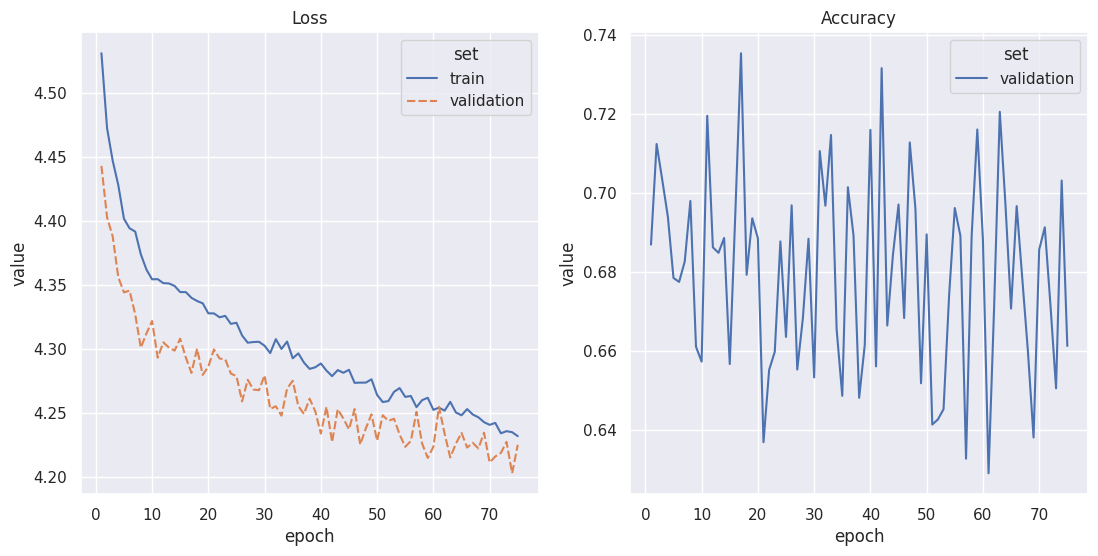

============================== EPOCH 76 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.69it/s]


Epoch 76, Learning Rate: 0.00010, Epoch time: 31.92 seconds
Loss: 4.236, Valid Loss: 4.1881, NMI: 0.8698, AMI: 0.6578, ARI: 0.6402, ACC: 0.7349, 
============================== EPOCH 77 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.27it/s]


Epoch 77, Learning Rate: 0.00010, Epoch time: 33.10 seconds
Loss: 4.231, Valid Loss: 4.2063, NMI: 0.8489, AMI: 0.6045, ARI: 0.5850, ACC: 0.6973, 
============================== EPOCH 78 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.08it/s]


Epoch 78, Learning Rate: 0.00010, Epoch time: 33.49 seconds
Loss: 4.227, Valid Loss: 4.2284, NMI: 0.8302, AMI: 0.5415, ARI: 0.5187, ACC: 0.6477, 
============================== EPOCH 79 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.94it/s]


Epoch 79, Learning Rate: 0.00010, Epoch time: 34.76 seconds
Loss: 4.234, Valid Loss: 4.2025, NMI: 0.8529, AMI: 0.6082, ARI: 0.5895, ACC: 0.6961, 
============================== EPOCH 80 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.15it/s]


Epoch 80, Learning Rate: 0.00010, Epoch time: 34.78 seconds
Loss: 4.234, Valid Loss: 4.1935, NMI: 0.8663, AMI: 0.6427, ARI: 0.6238, ACC: 0.7226, 


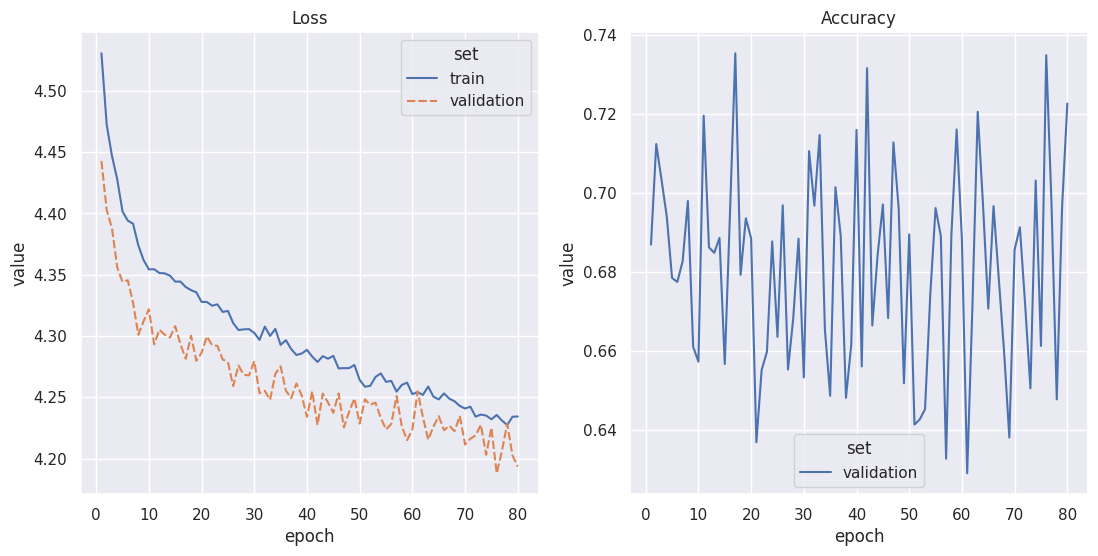

============================== EPOCH 81 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.11it/s]


Epoch 81, Learning Rate: 0.00010, Epoch time: 34.41 seconds
Loss: 4.234, Valid Loss: 4.2151, NMI: 0.8441, AMI: 0.5815, ARI: 0.5595, ACC: 0.6724, 
============================== EPOCH 82 ==============================


Validation: 100%|██████████| 157/157 [00:10<00:00, 15.34it/s]


Epoch 82, Learning Rate: 0.00010, Epoch time: 35.85 seconds
Loss: 4.226, Valid Loss: 4.2147, NMI: 0.8438, AMI: 0.5914, ARI: 0.5698, ACC: 0.6838, 
============================== EPOCH 83 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.11it/s]


Epoch 83, Learning Rate: 0.00010, Epoch time: 34.29 seconds
Loss: 4.227, Valid Loss: 4.1852, NMI: 0.8690, AMI: 0.6504, ARI: 0.6339, ACC: 0.7336, 
============================== EPOCH 84 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.23it/s]


Epoch 84, Learning Rate: 0.00010, Epoch time: 34.30 seconds
Loss: 4.229, Valid Loss: 4.2130, NMI: 0.8428, AMI: 0.5798, ARI: 0.5593, ACC: 0.6783, 
============================== EPOCH 85 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.99it/s]


Epoch 85, Learning Rate: 0.00010, Epoch time: 34.50 seconds
Loss: 4.222, Valid Loss: 4.2214, NMI: 0.8380, AMI: 0.5826, ARI: 0.5601, ACC: 0.6784, 


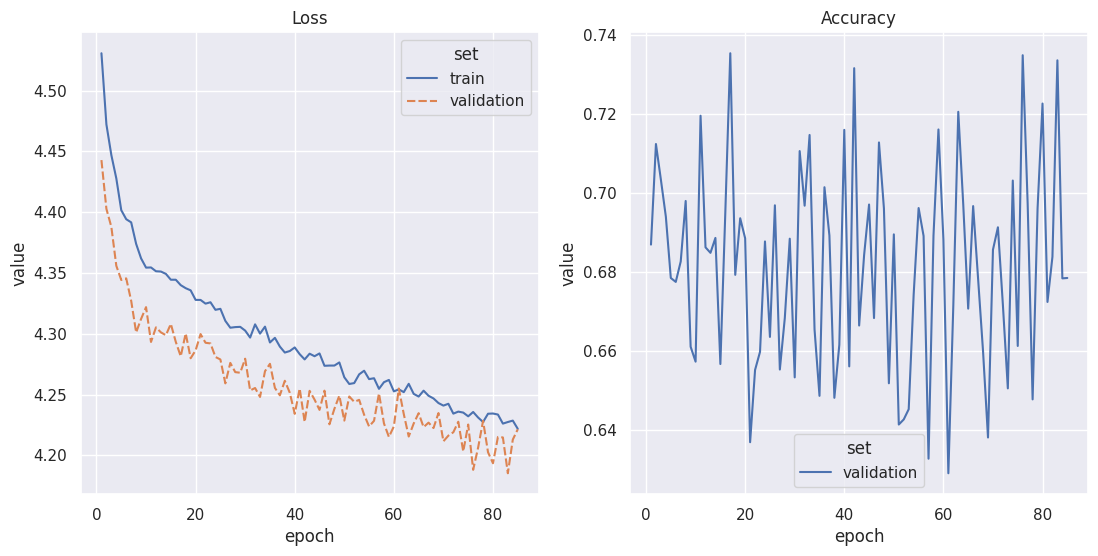

============================== EPOCH 86 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


Epoch 86, Learning Rate: 0.00010, Epoch time: 34.14 seconds
Loss: 4.229, Valid Loss: 4.2177, NMI: 0.8402, AMI: 0.5752, ARI: 0.5527, ACC: 0.6729, 
============================== EPOCH 87 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


Epoch 87, Learning Rate: 0.00010, Epoch time: 33.94 seconds
Loss: 4.232, Valid Loss: 4.2189, NMI: 0.8379, AMI: 0.5762, ARI: 0.5563, ACC: 0.6712, 
============================== EPOCH 88 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


Epoch 88, Learning Rate: 0.00010, Epoch time: 34.37 seconds
Loss: 4.227, Valid Loss: 4.2099, NMI: 0.8461, AMI: 0.5873, ARI: 0.5672, ACC: 0.6816, 
============================== EPOCH 89 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.11it/s]


Epoch 89, Learning Rate: 0.00010, Epoch time: 33.80 seconds
Loss: 4.221, Valid Loss: 4.2175, NMI: 0.8351, AMI: 0.5598, ARI: 0.5374, ACC: 0.6622, 
============================== EPOCH 90 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


Epoch 90, Learning Rate: 0.00010, Epoch time: 34.22 seconds
Loss: 4.221, Valid Loss: 4.1915, NMI: 0.8632, AMI: 0.6360, ARI: 0.6176, ACC: 0.7171, 


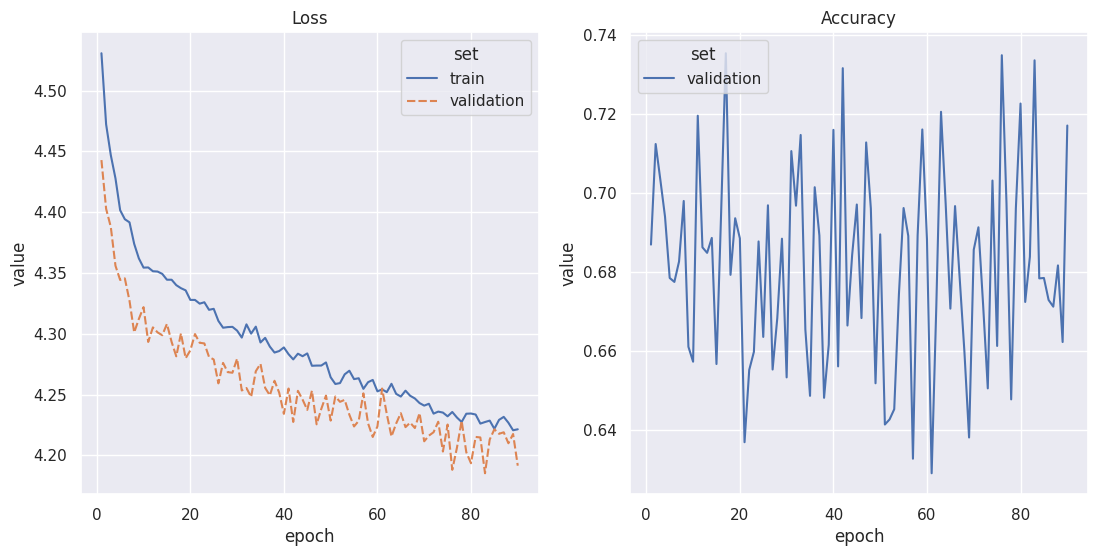

============================== EPOCH 91 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 16.60it/s]


Epoch 91, Learning Rate: 0.00010, Epoch time: 34.12 seconds
Loss: 4.229, Valid Loss: 4.2071, NMI: 0.8494, AMI: 0.5977, ARI: 0.5771, ACC: 0.6907, 
============================== EPOCH 92 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.06it/s]


Epoch 92, Learning Rate: 0.00010, Epoch time: 34.29 seconds
Loss: 4.222, Valid Loss: 4.2204, NMI: 0.8361, AMI: 0.5727, ARI: 0.5498, ACC: 0.6737, 
============================== EPOCH 93 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.08it/s]


Epoch 93, Learning Rate: 0.00010, Epoch time: 34.48 seconds
Loss: 4.228, Valid Loss: 4.2295, NMI: 0.8251, AMI: 0.5397, ARI: 0.5177, ACC: 0.6457, 
============================== EPOCH 94 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.02it/s]


Epoch 94, Learning Rate: 0.00010, Epoch time: 34.02 seconds
Loss: 4.216, Valid Loss: 4.2119, NMI: 0.8440, AMI: 0.5823, ARI: 0.5611, ACC: 0.6773, 
============================== EPOCH 95 ==============================


Validation: 100%|██████████| 157/157 [00:09<00:00, 17.37it/s]


Epoch 95, Learning Rate: 0.00010, Epoch time: 34.32 seconds
Loss: 4.221, Valid Loss: 4.1997, NMI: 0.8559, AMI: 0.6132, ARI: 0.5927, ACC: 0.7030, 


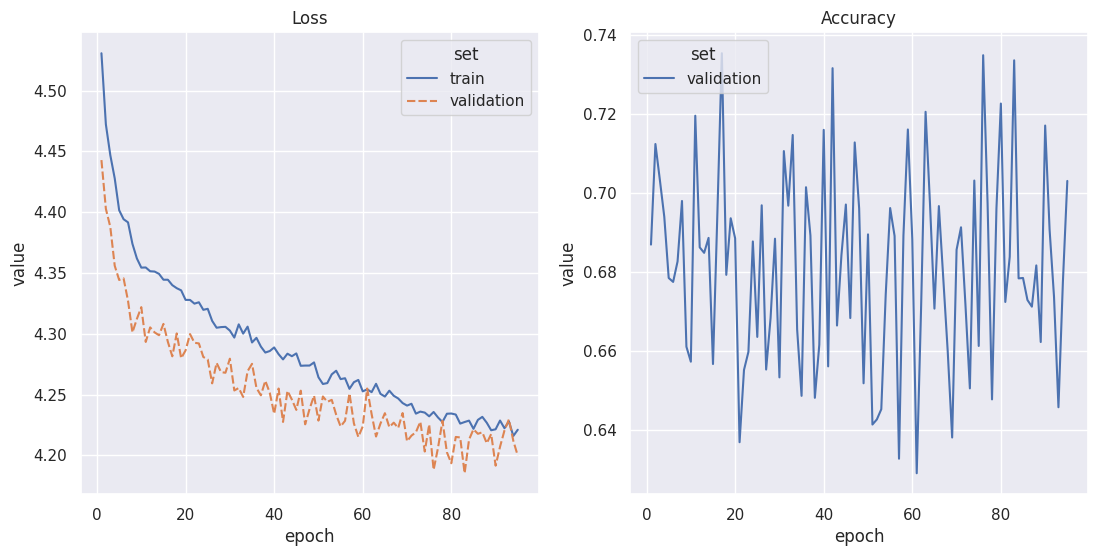

============================== EPOCH 96 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.29it/s]


Epoch 96, Learning Rate: 0.00010, Epoch time: 32.41 seconds
Loss: 4.220, Valid Loss: 4.2000, NMI: 0.8540, AMI: 0.6043, ARI: 0.5867, ACC: 0.6966, 
============================== EPOCH 97 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.53it/s]


Epoch 97, Learning Rate: 0.00010, Epoch time: 32.26 seconds
Loss: 4.219, Valid Loss: 4.2063, NMI: 0.8510, AMI: 0.6014, ARI: 0.5820, ACC: 0.6919, 
============================== EPOCH 98 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.67it/s]


Epoch 98, Learning Rate: 0.00010, Epoch time: 31.86 seconds
Loss: 4.221, Valid Loss: 4.2156, NMI: 0.8433, AMI: 0.5847, ARI: 0.5617, ACC: 0.6792, 
============================== EPOCH 99 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.43it/s]


Epoch 99, Learning Rate: 0.00010, Epoch time: 32.24 seconds
Loss: 4.209, Valid Loss: 4.2270, NMI: 0.8314, AMI: 0.5528, ARI: 0.5297, ACC: 0.6555, 
============================== EPOCH 100 ==============================


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.66it/s]


Epoch 100, Learning Rate: 0.00010, Epoch time: 31.70 seconds
Loss: 4.217, Valid Loss: 4.2104, NMI: 0.8433, AMI: 0.5860, ARI: 0.5630, ACC: 0.6794, 


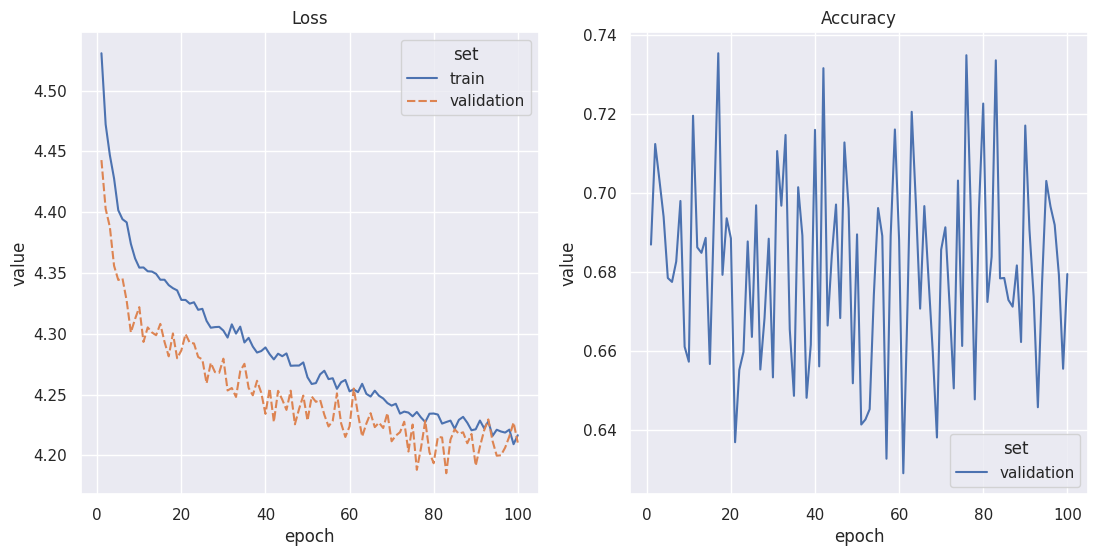


<<<<<<<<<<<<<<<<<<<<<<<<<< FINISHED 3495.83s >>>>>>>>>>>>>>>>>>>>>>>>>>


(4.2104383, 0.6794386942675159)

In [9]:
training_run()

In [ ]:
def objective(trial):
    # Create a data recorder and fit the data
    recorder = DataRecorder()

    # Instansiate loss function
    loss_object_test = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Instansiate SelfClassifier loss function
    loss_object_train = SelfClassifier(n_batch=config['BATCH_SIZE'], 
                        n_class=config['CLASS_COUNT'], t_r=0.1, t_c=0.05)
    # Instansiate optimizer 
    optimizer = copy.deepcopy(config['OPTIM'])
    optimizer.learning_rate = lr_schedular(config['LR_SCHED'],len(train_ds))

    #backbone = trial.suggest_categorical('backbone',[
        "ResNet50", "EfficientNetB0", "EfficientNetB1", "MobileNet"])
    
    # Create an instance of the model
    model = PretrainedModel(pre_model=backbone,input_shape=x_train.shape[1:])

    learner = UnderSupervisedLearner(model=model, optimizer=optimizer,
                                 loss_object_train=loss_object_train,
                                 loss_object_test=loss_object_test,
                                 data_augmentation=aug_seq,
                                 recorder=recorder)
    # Train the model
    return learner.fit(plot_every=5, 
                       wait_epoch=int(config['EPOCHS']*0.1))


In [ ]:
import logging
import sys
import optuna

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "cifar100-backbone-study"  # Unique identifier of the study.
storage_name = "sqlite:///studies/{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, 
                            directions=["minimize", "maximize"],
                            load_if_exists=True)

[I 2022-12-02 12:41:46,703] A new study created in RDB with name: cifar100-backbone-study


A new study created in RDB with name: cifar100-backbone-study


============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 92.80 seconds
Loss: 2.014, Valid Loss: 1.5478, NMI: 0.4812, AMI: 0.4584, ARI: 0.4299, ACC: 0.6235, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 92.16 seconds
Loss: 2.154, Valid Loss: 2.0266, NMI: 0.3950, AMI: 0.3905, ARI: 0.4346, ACC: 0.7233, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 74.44 seconds
Loss: 2.067, Valid Loss: 1.9437, NMI: 0.3995, AMI: 0.3933, ARI: 0.3996, ACC: 0.6789, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 88.24 seconds
Loss: 2.003, Valid Loss: 1.8646, NMI: 0.3878, AMI: 0.3774, ARI: 0.3862, ACC: 0.6701, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 92.16 seconds
Loss: 1.910, Valid Loss: 1.7443, NMI: 0.3456, AMI: 0.3219, ARI: 0.2786, ACC: 0.5568, 


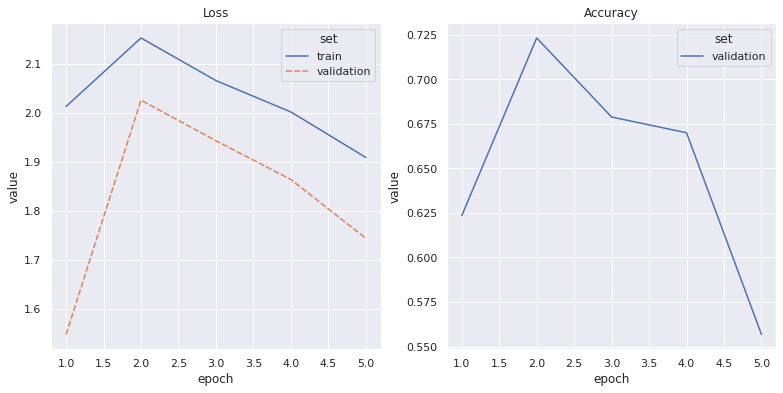

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 71.34 seconds
Loss: 1.744, Valid Loss: 1.5169, NMI: 0.4329, AMI: 0.4087, ARI: 0.3466, ACC: 0.5735, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 69.51 seconds
Loss: 1.659, Valid Loss: 1.4684, NMI: 0.4744, AMI: 0.4530, ARI: 0.4149, ACC: 0.6246, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 92.15 seconds
Loss: 1.617, Valid Loss: 1.4343, NMI: 0.4735, AMI: 0.4511, ARI: 0.3991, ACC: 0.6145, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 9, Learning Rate: 0.00442, Epoch time: 88.40 seconds
Loss: 1.596, Valid Loss: 1.3877, NMI: 0.5115, AMI: 0.4922, ARI: 0.4409, ACC: 0.6452, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 10, Learning Rate: 0.00422, Epoch time: 92.16 seconds
Loss: 1.544, Valid Loss: 1.4675, NMI: 0.4178, AMI: 0.3931, ARI: 0.3273, ACC: 0.5835, 


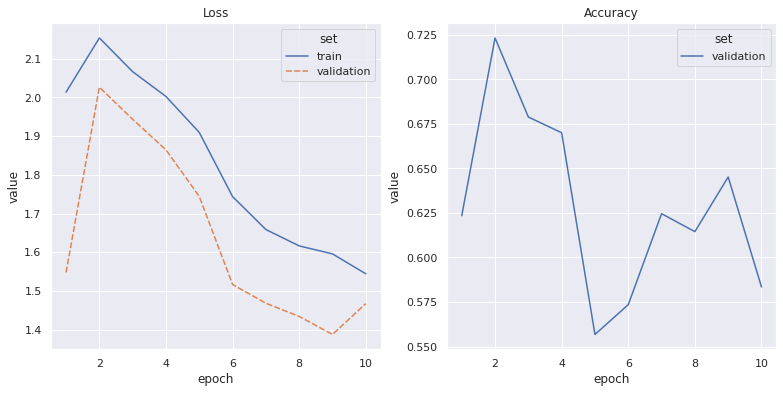

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 11, Learning Rate: 0.00399, Epoch time: 92.17 seconds
Loss: 1.613, Valid Loss: 1.3838, NMI: 0.4827, AMI: 0.4597, ARI: 0.4112, ACC: 0.6350, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 12, Learning Rate: 0.00375, Epoch time: 92.17 seconds
Loss: 1.561, Valid Loss: 1.4886, NMI: 0.3772, AMI: 0.3511, ARI: 0.2848, ACC: 0.5488, 
============================== EPOCH 13 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 13, Learning Rate: 0.00349, Epoch time: 69.78 seconds
Loss: 1.542, Valid Loss: 1.3263, NMI: 0.4935, AMI: 0.4723, ARI: 0.4179, ACC: 0.6342, 
============================== EPOCH 14 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 14, Learning Rate: 0.00322, Epoch time: 70.12 seconds
Loss: 1.571, Valid Loss: 1.3931, NMI: 0.4181, AMI: 0.3939, ARI: 0.3337, ACC: 0.5846, 
============================== EPOCH 15 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Epoch 15, Learning Rate: 0.00293, Epoch time: 88.17 seconds
Loss: 1.556, Valid Loss: 1.3137, NMI: 0.4867, AMI: 0.4651, ARI: 0.4090, ACC: 0.6329, 


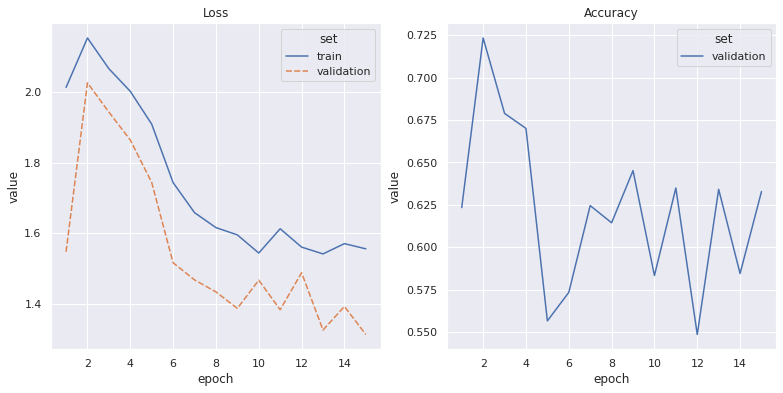

============================== EPOCH 16 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 16, Learning Rate: 0.00265, Epoch time: 92.17 seconds
Loss: 1.509, Valid Loss: 1.3596, NMI: 0.4571, AMI: 0.4341, ARI: 0.3770, ACC: 0.6150, 
============================== EPOCH 17 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 17, Learning Rate: 0.00235, Epoch time: 74.10 seconds
Loss: 1.523, Valid Loss: 1.3667, NMI: 0.4546, AMI: 0.4320, ARI: 0.3782, ACC: 0.6092, 
============================== EPOCH 18 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 18, Learning Rate: 0.00207, Epoch time: 88.28 seconds
Loss: 1.497, Valid Loss: 1.3695, NMI: 0.4536, AMI: 0.4310, ARI: 0.3703, ACC: 0.6080, 
============================== EPOCH 19 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]
[I 2022-12-02 13:08:35,107] Trial 0 finished with values: [1.3137437105178833, 0.6328756893382353] and parameters: {'backbone': 'EfficientNetB1'}. 


Epoch 19, Learning Rate: 0.00178, Epoch time: 72.90 seconds
Loss: 1.497, Valid Loss: 1.4311, NMI: 0.3926, AMI: 0.3674, ARI: 0.3014, ACC: 0.5631, 
Out of patience! Returning 0.6329
Trial 0 finished with values: [1.3137437105178833, 0.6328756893382353] and parameters: {'backbone': 'EfficientNetB1'}. 
============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 73.33 seconds
Loss: 1.999, Valid Loss: 1.6442, NMI: 0.4758, AMI: 0.4541, ARI: 0.4603, ACC: 0.6551, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 69.28 seconds
Loss: 1.746, Valid Loss: 1.6137, NMI: 0.3911, AMI: 0.3643, ARI: 0.3241, ACC: 0.5623, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 92.17 seconds
Loss: 1.735, Valid Loss: 1.4734, NMI: 0.4686, AMI: 0.4460, ARI: 0.3898, ACC: 0.6109, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 73.06 seconds
Loss: 1.652, Valid Loss: 1.5130, NMI: 0.4402, AMI: 0.4144, ARI: 0.3860, ACC: 0.6114, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 92.16 seconds
Loss: 1.571, Valid Loss: 1.5197, NMI: 0.4387, AMI: 0.4163, ARI: 0.3573, ACC: 0.5934, 


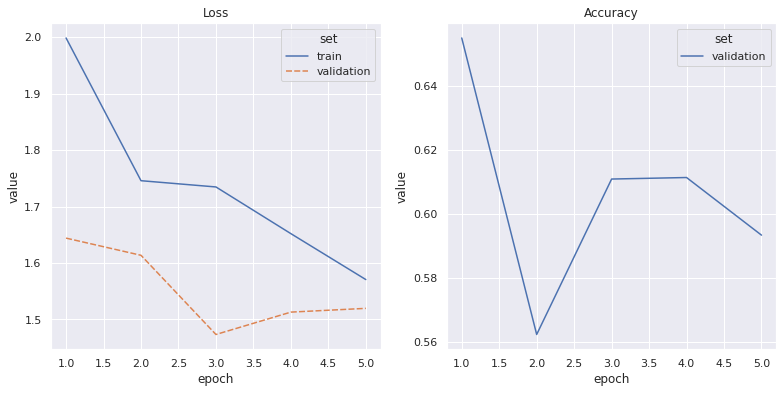

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 92.17 seconds
Loss: 1.625, Valid Loss: 1.5373, NMI: 0.4081, AMI: 0.3818, ARI: 0.3530, ACC: 0.5930, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 92.16 seconds
Loss: 1.589, Valid Loss: 1.5137, NMI: 0.4003, AMI: 0.3770, ARI: 0.3174, ACC: 0.5663, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 92.16 seconds
Loss: 1.587, Valid Loss: 1.2657, NMI: 0.5504, AMI: 0.5311, ARI: 0.4912, ACC: 0.6811, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 9, Learning Rate: 0.00442, Epoch time: 72.82 seconds
Loss: 1.595, Valid Loss: 1.4018, NMI: 0.4479, AMI: 0.4242, ARI: 0.3858, ACC: 0.6164, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 10, Learning Rate: 0.00422, Epoch time: 92.16 seconds
Loss: 1.541, Valid Loss: 1.4814, NMI: 0.3783, AMI: 0.3520, ARI: 0.2954, ACC: 0.5636, 


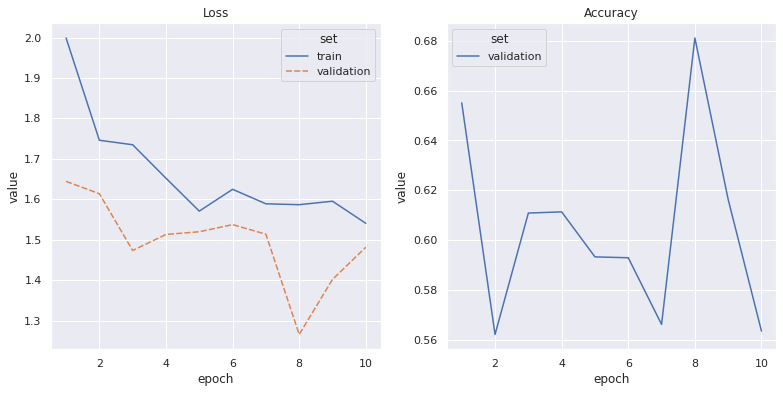

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 11, Learning Rate: 0.00399, Epoch time: 72.10 seconds
Loss: 1.547, Valid Loss: 1.5024, NMI: 0.3447, AMI: 0.3173, ARI: 0.2579, ACC: 0.5416, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
[I 2022-12-02 13:25:00,741] Trial 1 finished with values: [1.2656738758087158, 0.6810834099264705] and parameters: {'backbone': 'EfficientNetB1'}. 


Epoch 12, Learning Rate: 0.00375, Epoch time: 68.52 seconds
Loss: 1.557, Valid Loss: 1.3173, NMI: 0.4940, AMI: 0.4721, ARI: 0.4251, ACC: 0.6495, 
Out of patience! Returning 0.6811
Trial 1 finished with values: [1.2656738758087158, 0.6810834099264705] and parameters: {'backbone': 'EfficientNetB1'}. 


============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.97it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 16.44 seconds
Loss: 2.290, Valid Loss: 2.2210, NMI: 0.2282, AMI: 0.2162, ARI: 0.2192, ACC: 0.5291, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 23.04 seconds
Loss: 2.263, Valid Loss: 2.1837, NMI: 0.2854, AMI: 0.2661, ARI: 0.2601, ACC: 0.4334, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 22.25 seconds
Loss: 2.276, Valid Loss: 2.2038, NMI: 0.2435, AMI: 0.2230, ARI: 0.2611, ACC: 0.6003, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.69it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 22.19 seconds
Loss: 2.269, Valid Loss: 2.2205, NMI: 0.1514, AMI: 0.1189, ARI: 0.1148, ACC: 0.3196, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 23.04 seconds
Loss: 2.244, Valid Loss: 2.2075, NMI: 0.2021, AMI: 0.1700, ARI: 0.2058, ACC: 0.4910, 


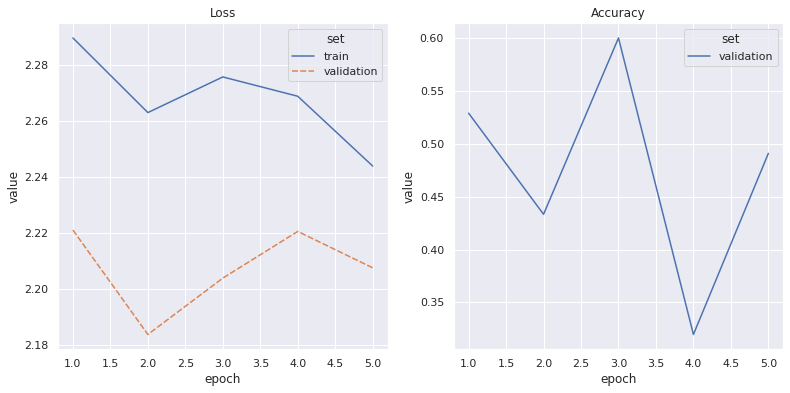

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 22.24 seconds
Loss: 2.252, Valid Loss: 2.1715, NMI: 0.2501, AMI: 0.2176, ARI: 0.2095, ACC: 0.3445, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 22.22 seconds
Loss: 2.219, Valid Loss: 2.0973, NMI: 0.3408, AMI: 0.3151, ARI: 0.3095, ACC: 0.4537, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 23.03 seconds
Loss: 2.259, Valid Loss: 2.1986, NMI: 0.2091, AMI: 0.1722, ARI: 0.1727, ACC: 0.3465, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Epoch 9, Learning Rate: 0.00442, Epoch time: 18.24 seconds
Loss: 2.193, Valid Loss: 2.1854, NMI: 0.2429, AMI: 0.2191, ARI: 0.2190, ACC: 0.4074, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


Epoch 10, Learning Rate: 0.00422, Epoch time: 22.19 seconds
Loss: 2.263, Valid Loss: 2.0706, NMI: 0.4366, AMI: 0.4129, ARI: 0.4079, ACC: 0.5171, 


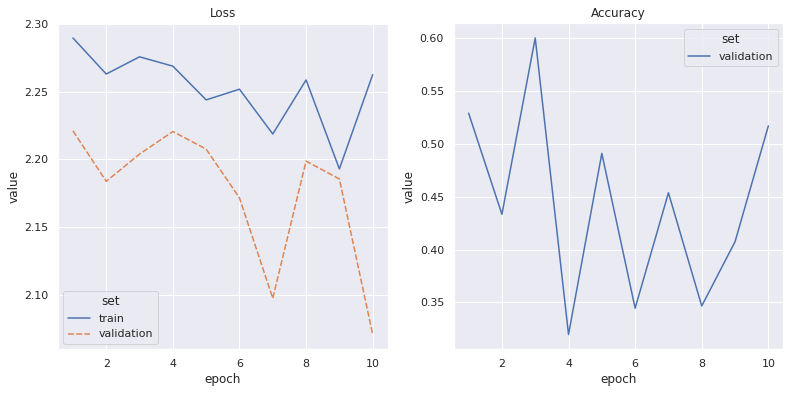

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.70it/s]


Epoch 11, Learning Rate: 0.00399, Epoch time: 16.38 seconds
Loss: 2.225, Valid Loss: 2.1951, NMI: 0.2008, AMI: 0.1669, ARI: 0.1755, ACC: 0.3672, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 20/20 [00:01<00:00, 12.01it/s]


Epoch 12, Learning Rate: 0.00375, Epoch time: 16.17 seconds
Loss: 2.258, Valid Loss: 2.1389, NMI: 0.2972, AMI: 0.2668, ARI: 0.2593, ACC: 0.3853, 
============================== EPOCH 13 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Epoch 13, Learning Rate: 0.00349, Epoch time: 17.08 seconds
Loss: 2.220, Valid Loss: 2.1231, NMI: 0.3034, AMI: 0.2710, ARI: 0.2644, ACC: 0.4156, 
============================== EPOCH 14 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]
[I 2022-12-02 13:29:44,385] Trial 2 finished with values: [2.070570707321167, 0.51708984375] and parameters: {'backbone': 'MobileNet'}. 


Epoch 14, Learning Rate: 0.00322, Epoch time: 17.19 seconds
Loss: 2.221, Valid Loss: 2.2196, NMI: 0.2004, AMI: 0.1691, ARI: 0.1588, ACC: 0.2868, 
Out of patience! Returning 0.5171
Trial 2 finished with values: [2.070570707321167, 0.51708984375] and parameters: {'backbone': 'MobileNet'}. 
============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 44.76 seconds
Loss: 2.904, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 39.08 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 41.29 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 40.11 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 46.07 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 


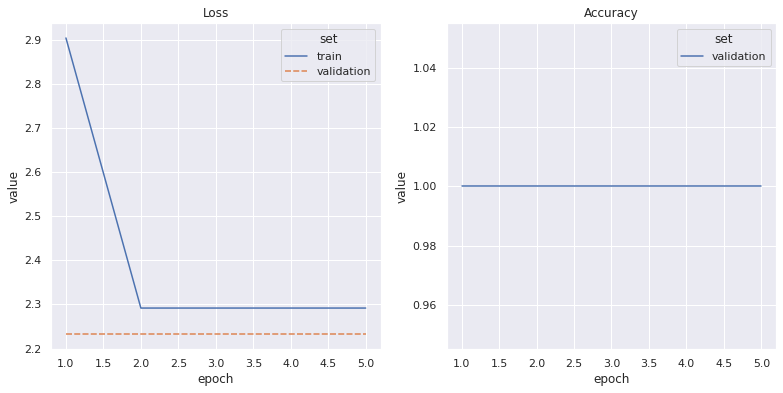

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.68it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 43.97 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 46.08 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 46.08 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]
[I 2022-12-02 13:36:19,036] Trial 3 finished with values: [2.2318167686462402, 1.0] and parameters: {'backbone': 'ResNet50'}. 


Epoch 9, Learning Rate: 0.00442, Epoch time: 44.85 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
Out of patience! Returning 1.0000
Trial 3 finished with values: [2.2318167686462402, 1.0] and parameters: {'backbone': 'ResNet50'}. 
============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 42.61 seconds
Loss: 2.980, Valid Loss: 2.5955, NMI: 0.2083, AMI: 0.2063, ARI: 0.3162, ACC: 0.8438, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 39.74 seconds
Loss: 2.309, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 43.91 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 41.57 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 46.08 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 


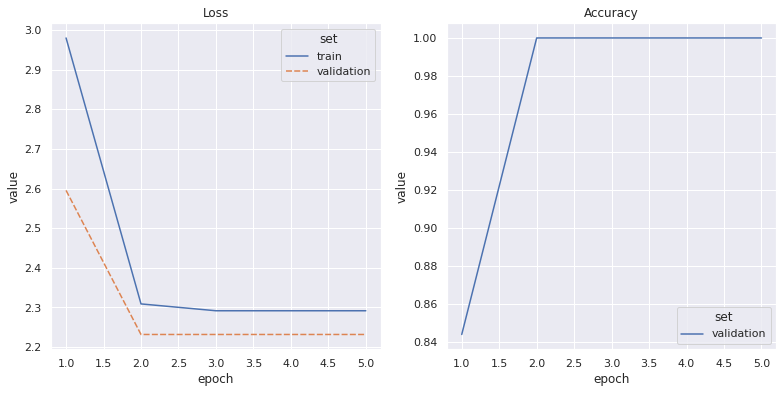

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 43.95 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 39.67 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 46.08 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]
[I 2022-12-02 13:42:48,740] Trial 4 finished with values: [2.2318167686462402, 1.0] and parameters: {'backbone': 'ResNet50'}. 


Epoch 9, Learning Rate: 0.00442, Epoch time: 43.92 seconds
Loss: 2.292, Valid Loss: 2.2318, NMI: 1.0000, AMI: 1.0000, ARI: 1.0000, ACC: 1.0000, 
Out of patience! Returning 1.0000
Trial 4 finished with values: [2.2318167686462402, 1.0] and parameters: {'backbone': 'ResNet50'}. 
============================== EPOCH 1 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 1, Learning Rate: 0.00333, Epoch time: 87.04 seconds
Loss: 1.969, Valid Loss: 1.5343, NMI: 0.4417, AMI: 0.4170, ARI: 0.3889, ACC: 0.5925, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch 2, Learning Rate: 0.00500, Epoch time: 86.49 seconds
Loss: 1.719, Valid Loss: 1.5703, NMI: 0.4127, AMI: 0.3862, ARI: 0.3594, ACC: 0.5904, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 3, Learning Rate: 0.00500, Epoch time: 87.03 seconds
Loss: 1.576, Valid Loss: 1.4591, NMI: 0.4737, AMI: 0.4507, ARI: 0.4160, ACC: 0.6305, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 4, Learning Rate: 0.00498, Epoch time: 87.04 seconds
Loss: 1.539, Valid Loss: 1.4493, NMI: 0.4245, AMI: 0.3995, ARI: 0.3537, ACC: 0.5905, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 5, Learning Rate: 0.00493, Epoch time: 87.03 seconds
Loss: 1.562, Valid Loss: 1.4133, NMI: 0.4545, AMI: 0.4310, ARI: 0.3784, ACC: 0.6069, 


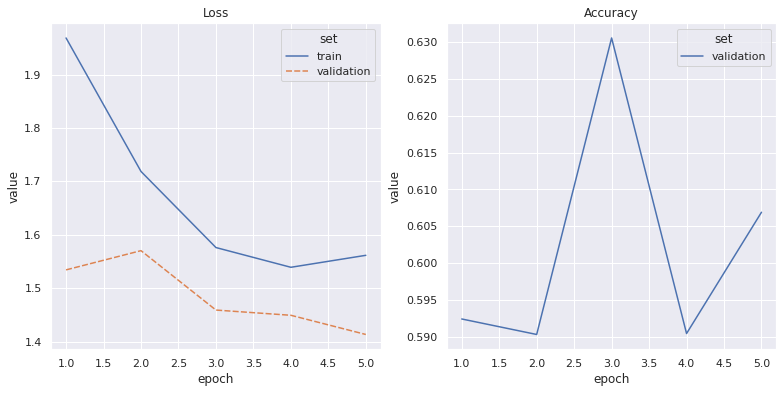

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


Epoch 6, Learning Rate: 0.00485, Epoch time: 48.90 seconds
Loss: 1.549, Valid Loss: 1.2870, NMI: 0.5271, AMI: 0.5069, ARI: 0.4511, ACC: 0.6569, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 7, Learning Rate: 0.00473, Epoch time: 86.40 seconds
Loss: 1.501, Valid Loss: 1.5384, NMI: 0.3804, AMI: 0.3527, ARI: 0.3136, ACC: 0.5775, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Epoch 8, Learning Rate: 0.00459, Epoch time: 48.94 seconds
Loss: 1.521, Valid Loss: 1.3691, NMI: 0.4604, AMI: 0.4384, ARI: 0.3846, ACC: 0.6115, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 9, Learning Rate: 0.00442, Epoch time: 49.54 seconds
Loss: 1.477, Valid Loss: 1.2642, NMI: 0.5353, AMI: 0.5150, ARI: 0.4785, ACC: 0.6771, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Epoch 10, Learning Rate: 0.00422, Epoch time: 48.96 seconds
Loss: 1.499, Valid Loss: 1.4880, NMI: 0.3516, AMI: 0.3239, ARI: 0.2771, ACC: 0.5556, 


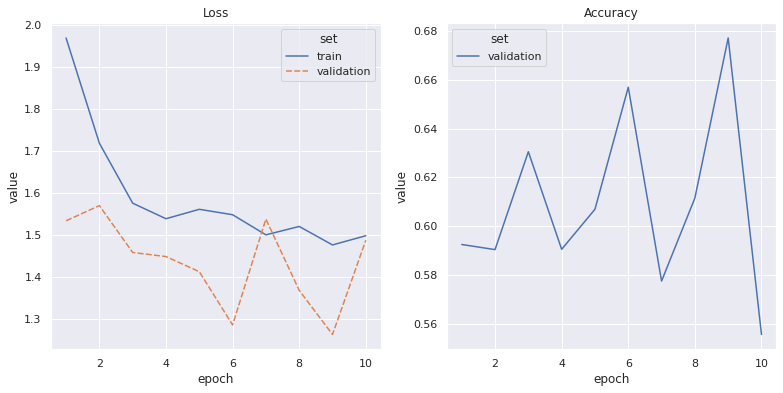

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Epoch 11, Learning Rate: 0.00399, Epoch time: 86.27 seconds
Loss: 1.472, Valid Loss: 1.2637, NMI: 0.5371, AMI: 0.5187, ARI: 0.4697, ACC: 0.6724, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Epoch 12, Learning Rate: 0.00375, Epoch time: 86.30 seconds
Loss: 1.451, Valid Loss: 1.2714, NMI: 0.4994, AMI: 0.4787, ARI: 0.4277, ACC: 0.6458, 
============================== EPOCH 13 ==============================


Training:  28%|██▊       | 27/98 [00:12<00:32,  2.16it/s]
[W 2022-12-02 13:57:54,039] Trial 5 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-87d7d335affe>", line 25, in objective
    return learner.fit(plot_every=5,
  File "<ipython-input-34-8cd157450cd8>", line 95, in fit
    self.train_step(a1, a2)
  File "<ipython-input-34-8cd157450cd8>", line 36, in train_step
    s2 = self.model(a2, training=True)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
    return super().__call__(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    

Trial 5 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-87d7d335affe>", line 25, in objective
    return learner.fit(plot_every=5,
  File "<ipython-input-34-8cd157450cd8>", line 95, in fit
    self.train_step(a1, a2)
  File "<ipython-input-34-8cd157450cd8>", line 36, in train_step
    s2 = self.model(a2, training=True)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
    return super().__call__(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine

KeyboardInterrupt: ignored

In [ ]:
study.optimize(objective, n_trials=10)

## Plot Final Metrics

In [ ]:
print(f"Number of trials: {len(study.trials)}")

trial_with_smallest_loss = min(study.best_trials, key=lambda t: t.values[0])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_smallest_loss.number}")
print(f"\tparams: {trial_with_smallest_loss.params}")
print(f"\tvalues: {trial_with_smallest_loss.values}")
print()

trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_highest_accuracy.number}")
print(f"\tparams: {trial_with_highest_accuracy.params}")
print(f"\tvalues: {trial_with_highest_accuracy.values}")

Number of trials: 6
Trial with highest accuracy: 
	number: 1
	params: {'backbone': 'EfficientNetB1'}
	values: [1.2656738758087158, 0.6810834099264705]

Trial with highest accuracy: 
	number: 3
	params: {'backbone': 'ResNet50'}
	values: [2.2318167686462402, 1.0]


In [ ]:
optuna.visualization.plot_pareto_front(study, target_names=["Loss", "Accuracy"])

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="Loss"
)

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="Accuracy"
)